In [3]:
!pip install pandasql -q

  Preparing metadata (setup.py) ... done


In [36]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta

In [6]:
# Load the CSV file into a pandas DataFrame
csv_file_path = '/content/orders.csv'
orders_df = pd.read_csv(csv_file_path)

# Make the DataFrame available for querying with pandasql
# The variable name of the DataFrame becomes the table name in SQL
globals().update(locals())

In [7]:
# Basic exploration
print("Dataset shape:", orders_df.shape)
print("\nColumn info:")
print(orders_df.info())
print("\nFirst few rows:")
print(orders_df.head())
print("\nBasic stats:")
print(orders_df.describe())

# Check date range
orders_df['created_at'] = pd.to_datetime(orders_df['created_at'])
print(f"\nDate range: {orders_df['created_at'].min()} to {orders_df['created_at'].max()}")

Dataset shape: (47402, 9)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47402 entries, 0 to 47401
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   invoice_id     47402 non-null  int64  
 1   line_item_id   47402 non-null  int64  
 2   user_id        47402 non-null  int64  
 3   item_id        47402 non-null  int64  
 4   item_name      47402 non-null  object 
 5   item_category  47402 non-null  object 
 6   price          47402 non-null  float64
 7   created_at     47402 non-null  object 
 8   paid_at        47402 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 3.3+ MB
None

First few rows:
   invoice_id  line_item_id  user_id  item_id  \
0      192320         83118   178481     3526   
1      192320        207309   178481     1514   
2      192320        392027   178481     3712   
3       80902        243831   154133     3586   
4       80902        399806   154133   

/tmp/ipython-input-7-1728277497.py:11: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  orders_df['created_at'] = pd.to_datetime(orders_df['created_at'])


In [8]:
# Check missing values
print("Missing values per column:")
print(orders_df.isnull().sum())
print(f"Missing value percentage:")
print((orders_df.isnull().sum() / len(orders_df)) * 100)

# Check for duplicates
print(f"\nDuplicate rows: {orders_df.duplicated().sum()}")

# Check for duplicate line items (shouldn't exist with unique line_item_id)
print(f"Duplicate line_item_ids: {orders_df['line_item_id'].duplicated().sum()}")

Missing values per column:
invoice_id       0
line_item_id     0
user_id          0
item_id          0
item_name        0
item_category    0
price            0
created_at       0
paid_at          0
dtype: int64
Missing value percentage:
invoice_id       0.0
line_item_id     0.0
user_id          0.0
item_id          0.0
item_name        0.0
item_category    0.0
price            0.0
created_at       0.0
paid_at          0.0
dtype: float64

Duplicate rows: 0
Duplicate line_item_ids: 0


In [9]:
# Convert date columns and handle any parsing issues
orders_df['created_at'] = pd.to_datetime(orders_df['created_at'], errors='coerce')
orders_df['paid_at'] = pd.to_datetime(orders_df['paid_at'], errors='coerce')

# Check for invalid dates
print("Invalid dates in 'created_at':", orders_df['created_at'].isnull().sum())
print("Invalid dates in 'paid_at':", orders_df['paid_at'].isnull().sum())

# Check date range and outliers
print(f"\nDate range for created_at: {orders_df['created_at'].min()} to {orders_df['created_at'].max()}")
print(f"\nDate range for paid_at: {orders_df['paid_at'].min()} to {orders_df['paid_at'].max()}")

# check for future dates (data quality issue)
today = pd.Timestamp.now()
future_orders = orders_df[orders_df['created_at'] > today]
print(f"\nFuture dated orders: {len(future_orders)}")

# check for paid_at before created_at
invalid_payment_dates = orders_df[orders_df['paid_at'] < orders_df['created_at']].dropna()
print(f"\nInvalid payment dates: {len(invalid_payment_dates)}")



Invalid dates in 'created_at': 0
Invalid dates in 'paid_at': 0

Date range for created_at: 2013-03-12 05:53:00 to 2018-06-01 23:55:00

Date range for paid_at: 2013-03-14 18:53:00 to 2018-06-04 13:41:00

Future dated orders: 0

Invalid payment dates: 18605


/tmp/ipython-input-9-2534472793.py:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  orders_df['paid_at'] = pd.to_datetime(orders_df['paid_at'], errors='coerce')


In [10]:
# Check price column for issues
print(f"Price column analysis")
print(f"Price range: {orders_df['price'].min()} to {orders_df['price'].max()}")
print(f"Negative prices: {(orders_df['price'] < 0).sum()}")
print(f"Zero prices: {(orders_df['price'] == 0).sum()}")
print(f"Null prices: {orders_df['price'].isnull().sum()}")

# Check for extremely high prices (potential data entry errors)
price_99th = orders_df['price'].quantile(0.99)
extreme_prices = orders_df[orders_df['price'] > price_99th * 10]
# 10x the 99th percentile
print(f"\nPotentially extreme prices: {len(extreme_prices)}")

if len(extreme_prices) > 0:
  print(f"\nExtreme price Examples:")
  print(extreme_prices[['item_name', 'price', 'item_category']])

Price column analysis
Price range: 0.0 to 2250.0
Negative prices: 0
Zero prices: 3318
Null prices: 0

Potentially extreme prices: 0


In [11]:
# Check ID columns for consistency
print("ID column validation:")
print(f"Unique users: {orders_df['user_id'].nunique()}")
print(f"Unique invoices: {orders_df['invoice_id'].nunique()}")
print(f"Unique line items: {orders_df['line_item_id'].nunique()}")
print(f"Unique items: {orders_df['item_id'].nunique()}")

# Check for missing IDs
id_columns = ['invoice_id', 'line_item_id', 'user_id', 'item_id']
for col in id_columns:
    null_count = orders_df[col].isnull().sum()
    print(f"Missing {col}: {null_count}")

ID column validation:
Unique users: 17463
Unique invoices: 18971
Unique line items: 47402
Unique items: 2198
Missing invoice_id: 0
Missing line_item_id: 0
Missing user_id: 0
Missing item_id: 0


In [12]:
# Clean item names and categories
print("Text data cleaning:")
print(f"Unique item categories: {orders_df['item_category'].nunique()}")
print("Category distribution:")
print(orders_df['item_category'].value_counts())

# Check for inconsistent category naming (case sensitivity, whitespace)
orders_df['item_category'] = orders_df['item_category'].str.strip().str.title()
orders_df['item_name'] = orders_df['item_name'].str.strip()

# Check for null categories
print(f"Null categories: {orders_df['item_category'].isnull().sum()}")
print(f"Null item names: {orders_df['item_name'].isnull().sum()}")

Text data cleaning:
Unique item categories: 10
Category distribution:
item_category
apparatus      4892
widget         4809
module         4800
instrument     4767
device         4735
mechanism      4706
contraption    4700
gadget         4695
dongle         4665
tool           4633
Name: count, dtype: int64
Null categories: 0
Null item names: 0


In [13]:
# Create cleaned dataset based on findings
print("=== DATA CLEANING DECISIONS ===")

# Store original size
original_size = len(orders_df)
print(f"Original dataset size: {original_size:,} rows")

# Remove rows with critical missing data
orders_df_cleaned = orders_df.copy()

# Remove rows with missing critical IDs or dates
orders_df_cleaned = orders_df_cleaned.dropna(subset=['user_id', 'invoice_id', 'line_item_id', 'created_at'])
print(f"After removing missing critical data: {len(orders_df_cleaned):,} rows")

# Remove negative prices (likely data errors)
orders_df_cleaned = orders_df_cleaned[orders_df_cleaned['price'] >= 0]
print(f"After removing negative prices: {len(orders_df_cleaned):,} rows")

# Remove future-dated orders
orders_df_cleaned = orders_df_cleaned[orders_df_cleaned['created_at'] <= today]
print(f"After removing future dates: {len(orders_df_cleaned):,} rows")

# Remove orders with invalid payment logic (paid before created)
orders_df_cleaned = orders_df_cleaned[~((orders_df_cleaned['paid_at'] < orders_df_cleaned['created_at']) &
                     orders_df_cleaned['paid_at'].notna())]
print(f"After removing invalid payment dates: {len(orders_df_cleaned):,} rows")

# Flag potential data quality issues for investigation
high_price_threshold = orders_df_cleaned['price'].quantile(0.999)  # 99.9th percentile
orders_df_cleaned['potential_price_outlier'] = orders_df_cleaned['price'] > high_price_threshold

print(f"\nFinal cleaned dataset: {len(orders_df_cleaned):,} rows")
print(f"Data retention rate: {len(orders_df_cleaned)/original_size:.1%}")

# Update our working dataframe
orders_df = orders_df_cleaned
print(len(orders_df))

=== DATA CLEANING DECISIONS ===
Original dataset size: 47,402 rows
After removing missing critical data: 47,402 rows
After removing negative prices: 47,402 rows
After removing future dates: 47,402 rows
After removing invalid payment dates: 28,797 rows

Final cleaned dataset: 28,797 rows
Data retention rate: 60.8%
28797


In [14]:
# Generate final data quality summary
print("\n=== FINAL DATA QUALITY SUMMARY ===")
print(f"Date range: {orders_df['created_at'].min().strftime('%Y-%m-%d')} to {orders_df['created_at'].max().strftime('%Y-%m-%d')}")
print(f"Total customers: {orders_df['user_id'].nunique():,}")
print(f"Total orders: {orders_df['invoice_id'].nunique():,}")
print(f"Total line items: {len(orders_df):,}")
print(f"Average order value: ${orders_df.groupby('invoice_id')['price'].sum().mean():.2f}")
print(f"Price range: ${orders_df['price'].min():.2f} to ${orders_df['price'].max():.2f}")
print(f"Categories: {orders_df['item_category'].nunique()}")

# Check cohort viability
cohort_months = orders_df.groupby(orders_df['created_at'].dt.to_period('M')).size()
print(f"\nCohort analysis viability:")
print(f"Number of months with data: {len(cohort_months)}")
print(f"Minimum monthly orders: {cohort_months.min()}")
print(f"Maximum monthly orders: {cohort_months.max()}")


=== FINAL DATA QUALITY SUMMARY ===
Date range: 2013-03-12 to 2018-06-01
Total customers: 10,891
Total orders: 11,454
Total line items: 28,797
Average order value: $255.75
Price range: $0.00 to $2250.00
Categories: 10

Cohort analysis viability:
Number of months with data: 64
Minimum monthly orders: 3
Maximum monthly orders: 795


In [ ]:
# Standard Cohort table Analysis

In [15]:
# Customer Cohorts
# Define cohort assignment query
cohort_query = """
SELECT
    user_id,
    DATE(MIN(created_at), 'start of month') as cohort_month,
    MIN(created_at) as first_purchase_date,
    COUNT(DISTINCT invoice_id) as total_orders,
    SUM(price) as total_spent
FROM orders_df
GROUP BY user_id
"""

customer_cohorts = sqldf(cohort_query)
print("Cohort summary:")
print(customer_cohorts.groupby('cohort_month').size())

Cohort summary:
cohort_month
2013-03-01      2
2013-04-01      6
2013-05-01     10
2013-06-01     13
2013-07-01     27
             ... 
2018-02-01    273
2018-03-01    281
2018-04-01    275
2018-05-01    280
2018-06-01     14
Length: 64, dtype: int64


In [16]:
# Monthly activity table
# Get all customer activity by month
monthly_activity_query = """
SELECT
    user_id,
    DATE(created_at, 'start of month') as activity_month,
    COUNT(DISTINCT invoice_id) as orders_that_month,
    SUM(price) as spent_that_month
FROM orders_df
GROUP BY user_id, DATE(created_at, 'start of month')
"""

monthly_activity = sqldf(monthly_activity_query)
print("Monthly activity sample:")
print(monthly_activity.head())
print(monthly_activity.tail())

Monthly activity sample:
   user_id activity_month  orders_that_month  spent_that_month
0       17     2013-05-01                  1            243.00
1       63     2013-07-01                  1            585.00
2       69     2013-08-01                  1              9.42
3       98     2013-08-01                  1            390.00
4      100     2013-04-01                  1            209.00
       user_id activity_month  orders_that_month  spent_that_month
11367   293087     2018-05-01                  1            120.00
11368   295368     2018-05-01                  1             45.00
11369   296332     2018-05-01                  1              4.65
11370   296584     2018-06-01                  1              8.82
11371   296887     2018-05-01                  1            144.00


In [17]:
# Combine cohort data with monthly activity
cohort_activity_query = """
SELECT
    c.user_id,
    c.cohort_month,
    c.first_purchase_date,
    m.activity_month,
    m.orders_that_month,
    m.spent_that_month,
    -- Calculate period number (0 = cohort month, 1 = month 1, etc.)
    CAST((julianday(m.activity_month) - julianday(c.cohort_month)) / 30.44 AS INTEGER) as period_number
FROM customer_cohorts c
LEFT JOIN monthly_activity m ON c.user_id = m.user_id
WHERE period_number >= 0 AND period_number <= 12
"""

cohort_activity = sqldf(cohort_activity_query)
print("Cohort activity sample:")
print(cohort_activity.head(10))

Cohort activity sample:
   user_id cohort_month         first_purchase_date activity_month  \
0       17   2013-05-01  2013-05-24 22:00:00.000000     2013-05-01   
1       63   2013-07-01  2013-07-04 23:19:00.000000     2013-07-01   
2       69   2013-08-01  2013-08-08 09:56:00.000000     2013-08-01   
3       98   2013-08-01  2013-08-21 01:21:00.000000     2013-08-01   
4      100   2013-04-01  2013-04-26 23:03:00.000000     2013-04-01   
5      105   2013-08-01  2013-08-27 12:34:00.000000     2013-08-01   
6      125   2013-05-01  2013-05-06 20:57:00.000000     2013-05-01   
7      145   2013-03-01  2013-03-12 05:53:00.000000     2013-03-01   
8      198   2013-05-01  2013-05-27 18:53:00.000000     2013-05-01   
9      199   2013-05-01  2013-05-25 03:52:00.000000     2013-05-01   

   orders_that_month  spent_that_month  period_number  
0                  1           243.000              0  
1                  1           585.000              0  
2                  1             9.42

In [18]:
# Create the standard cohort retention table
cohort_table_query = """
SELECT
    cohort_month,
    period_number,
    COUNT(DISTINCT user_id) as customers
FROM cohort_activity
WHERE activity_month IS NOT NULL  -- Only count active customers
GROUP BY cohort_month, period_number
ORDER BY cohort_month, period_number
"""

cohort_table = sqldf(cohort_table_query)

# Get cohort sizes (period 0 customers)
cohort_sizes_query = """
SELECT
    cohort_month,
    COUNT(DISTINCT user_id) as cohort_size
FROM customer_cohorts
GROUP BY cohort_month
"""

cohort_sizes = sqldf(cohort_sizes_query)

# Calculate retention percentages
retention_query = """
SELECT
    ct.cohort_month,
    ct.period_number,
    ct.customers,
    cs.cohort_size,
    ROUND(100.0 * ct.customers / cs.cohort_size, 2) as retention_rate
FROM cohort_table ct
JOIN cohort_sizes cs ON ct.cohort_month = cs.cohort_month
ORDER BY ct.cohort_month, ct.period_number
"""
retention_rates = sqldf(retention_query)

# Create standard retention pivot
cohort_pivot = retention_rates.pivot(index='cohort_month',
                                     columns='period_number',
                                     values='retention_rate')

print("Standard Cohort Retention Table:")
print(cohort_pivot.fillna(0))

Standard Cohort Retention Table:
period_number      0     1     2    3    4      5    6
cohort_month                                          
2013-03-01     100.0  0.00  0.00  0.0  0.0   0.00  0.0
2013-04-01     100.0  0.00  0.00  0.0  0.0  16.67  0.0
2013-05-01     100.0  0.00  0.00  0.0  0.0   0.00  0.0
2013-06-01     100.0  0.00  0.00  0.0  0.0   7.69  0.0
2013-07-01     100.0  0.00  0.00  3.7  0.0   0.00  0.0
...              ...   ...   ...  ...  ...    ...  ...
2018-02-01     100.0  0.37  1.47  0.0  0.0   0.00  0.0
2018-03-01     100.0  1.07  1.42  0.0  0.0   0.00  0.0
2018-04-01     100.0  0.00  0.00  0.0  0.0   0.00  0.0
2018-05-01     100.0  0.00  0.00  0.0  0.0   0.00  0.0
2018-06-01     100.0  0.00  0.00  0.0  0.0   0.00  0.0

[64 rows x 7 columns]


In [ ]:
# Resurrection Analysis

In [19]:
# Identify churned customers
# Find customers who were inactive for 2+ months then returned
resurrection_query = """
WITH customer_monthly_status AS (
    -- Create a complete timeline for each customer
    SELECT DISTINCT
        c.user_id,
        c.cohort_month,
        dates.month_date,
        CASE WHEN m.activity_month IS NOT NULL THEN 1 ELSE 0 END as was_active,
        CAST((julianday(dates.month_date) - julianday(c.cohort_month)) / 30.44 AS INTEGER) as period_number
    FROM customer_cohorts c
    CROSS JOIN (
        SELECT DISTINCT DATE(created_at, 'start of month') as month_date
        FROM orders_df
        ORDER BY month_date
    ) dates
    LEFT JOIN monthly_activity m ON c.user_id = m.user_id AND dates.month_date = m.activity_month
    WHERE period_number >= 0 AND period_number <= 12
),
inactive_periods AS (
    -- Identify periods of inactivity
    SELECT
        user_id,
        cohort_month,
        month_date,
        period_number,
        was_active,
        -- Count consecutive inactive months
        SUM(CASE WHEN was_active = 0 THEN 1 ELSE 0 END)
        OVER (PARTITION BY user_id ORDER BY month_date
              ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) as inactive_streak
    FROM customer_monthly_status
)
SELECT
    cohort_month,
    period_number,
    COUNT(DISTINCT CASE WHEN was_active = 1 AND inactive_streak >= 2 THEN user_id END) as resurrected_customers,
    COUNT(DISTINCT user_id) as total_customers_in_period
FROM inactive_periods
WHERE period_number > 0  -- Skip acquisition month
GROUP BY cohort_month, period_number
ORDER BY cohort_month, period_number
"""

resurrection_data = sqldf(resurrection_query)
print("Resurrection analysis sample:")
print(resurrection_data.head(10))

Resurrection analysis sample:
  cohort_month  period_number  resurrected_customers  \
0   2013-03-01              1                      0   
1   2013-03-01              2                      0   
2   2013-03-01              3                      0   
3   2013-03-01              4                      0   
4   2013-03-01              5                      0   
5   2013-03-01              6                      0   
6   2013-03-01              7                      0   
7   2013-03-01              8                      0   
8   2013-03-01              9                      0   
9   2013-03-01             10                      0   

   total_customers_in_period  
0                          2  
1                          2  
2                          2  
3                          2  
4                          2  
5                          2  
6                          2  
7                          2  
8                          2  
9                          2  


In [20]:
# Calculate resurrection rates by cohort
resurrection_rates_query = """
SELECT
    cohort_month,
    period_number,
    resurrected_customers,
    ROUND(100.0 * resurrected_customers /
          NULLIF(total_customers_in_period, 0), 2) as resurrection_rate
FROM resurrection_data
WHERE resurrected_customers > 0
"""

resurrection_rates = sqldf(resurrection_rates_query)

# Create resurrection pivot table
resurrection_pivot = resurrection_rates.pivot(index='cohort_month',
                                            columns='period_number',
                                            values='resurrection_rate')

print("Resurrection Rates Table:")
print(resurrection_pivot.fillna(0))

Resurrection Rates Table:
period_number     2     3     4      5     6
cohort_month                                
2013-04-01     0.00  0.00  0.00  16.67  0.00
2013-06-01     0.00  0.00  0.00   7.69  0.00
2013-07-01     0.00  3.70  0.00   0.00  0.00
2013-08-01     0.00  0.00  2.86   0.00  0.00
2013-09-01     0.00  0.00  2.00   2.00  0.00
2013-10-01     0.00  5.66  0.00   3.77  0.00
2013-11-01     0.00  0.00  1.89   0.00  0.00
2013-12-01     0.00  1.33  0.00   0.00  0.00
2014-01-01     1.35  0.00  0.00   0.00  0.00
2014-02-01     1.32  0.00  0.00   0.00  0.00
2014-03-01     0.00  1.45  1.45   0.00  0.00
2014-04-01     1.05  0.00  1.05   3.16  0.00
2014-05-01     0.00  2.80  0.00   0.00  0.00
2014-06-01     0.00  1.92  2.88   0.00  0.00
2014-07-01     0.00  0.00  0.00   0.72  0.00
2014-08-01     0.00  0.82  0.00   1.64  0.00
2014-09-01     0.91  0.00  0.00   0.91  0.00
2014-10-01     0.00  0.80  2.40   0.00  0.00
2014-11-01     0.00  1.35  0.68   0.00  0.00
2014-12-01     0.63  0.63  0.

In [24]:
# Quality retention analysis

In [21]:
# Filter out low-value customers (< $50 total spend)
quality_customers_query = """
SELECT user_id, cohort_month, total_spent
FROM customer_cohorts
WHERE total_spent >= 50
"""

quality_customers = sqldf(quality_customers_query)

print(f"Quality customers: {len(quality_customers)} out of {len(customer_cohorts)} total")
print(f"Percentage of quality customers: {100 * len(quality_customers) / len(customer_cohorts):.1f}%")

# Recalculate retention for quality customers only
quality_retention_query = """
SELECT
    ct.cohort_month,
    ct.period_number,
    COUNT(DISTINCT ct.user_id) as quality_customers,
    cs.quality_cohort_size,
    ROUND(100.0 * COUNT(DISTINCT ct.user_id) / NULLIF(cs.quality_cohort_size, 0), 2) as quality_retention_rate
FROM cohort_activity ct
JOIN quality_customers qc ON ct.user_id = qc.user_id
JOIN (
    SELECT cohort_month, COUNT(*) as quality_cohort_size
    FROM quality_customers
    GROUP BY cohort_month
) cs ON ct.cohort_month = cs.cohort_month
WHERE ct.activity_month IS NOT NULL
GROUP BY ct.cohort_month, ct.period_number
ORDER BY ct.cohort_month, ct.period_number
"""

quality_retention = sqldf(quality_retention_query)

# Create quality retention pivot
quality_pivot = quality_retention.pivot(index='cohort_month',
                                       columns='period_number',
                                       values='quality_retention_rate')

print("Quality Retention Table (excluding <$50 customers):")
print(quality_pivot.fillna(0))


Quality customers: 7806 out of 10891 total
Percentage of quality customers: 71.7%
Quality Retention Table (excluding <$50 customers):
period_number      0     1     2     3    4      5    6
cohort_month                                           
2013-03-01     100.0  0.00  0.00  0.00  0.0   0.00  0.0
2013-04-01     100.0  0.00  0.00  0.00  0.0  33.33  0.0
2013-05-01     100.0  0.00  0.00  0.00  0.0   0.00  0.0
2013-06-01     100.0  0.00  0.00  0.00  0.0  11.11  0.0
2013-07-01     100.0  0.00  0.00  4.76  0.0   0.00  0.0
...              ...   ...   ...   ...  ...    ...  ...
2018-02-01     100.0  0.51  2.03  0.00  0.0   0.00  0.0
2018-03-01     100.0  1.45  1.45  0.00  0.0   0.00  0.0
2018-04-01     100.0  0.00  0.00  0.00  0.0   0.00  0.0
2018-05-01     100.0  0.00  0.00  0.00  0.0   0.00  0.0
2018-06-01     100.0  0.00  0.00  0.00  0.0   0.00  0.0

[64 rows x 7 columns]


In [ ]:
# Comparing standard VS quality retention

In [22]:
# Compare standard vs quality retention for Month 6
comparison_query = """
WITH standard_month6 AS (
    SELECT cohort_month, retention_rate as standard_retention
    FROM retention_rates
    WHERE period_number = 6
),
quality_month6 AS (
    SELECT cohort_month, quality_retention_rate as quality_retention
    FROM quality_retention
    WHERE period_number = 6
)
SELECT
    s.cohort_month,
    s.standard_retention,
    q.quality_retention,
    (q.quality_retention - s.standard_retention) as retention_lift
FROM standard_month6 s
JOIN quality_month6 q ON s.cohort_month = q.cohort_month
ORDER BY s.cohort_month
"""

retention_comparison = sqldf(comparison_query)
print("Standard vs Quality Retention (Month 6):")
print(retention_comparison)

Standard vs Quality Retention (Month 6):
  cohort_month  standard_retention  quality_retention  retention_lift
0   2015-03-01                0.60               0.88            0.28
1   2015-07-01                0.63               0.88            0.25
2   2015-08-01                1.01               1.42            0.41
3   2016-07-01                0.44               0.68            0.24
4   2017-04-01                0.42               0.59            0.17
5   2017-07-01                0.36               0.47            0.11
6   2017-08-01                0.37               0.56            0.19


In [ ]:
# Summary & Business Insights

In [23]:
# Generate summary statistics
print("=== COHORT RETENTION ANALYSIS SUMMARY ===\n")

# Overall retention trends
avg_retention_by_period = retention_rates.groupby('period_number')['retention_rate'].mean()
print("Average retention by period:")
for period, rate in avg_retention_by_period.items():
    if period <= 6:  # Focus on first 6 months
        print(f"Month {period}: {rate:.1f}%")

print(f"\nQuality customer impact:")
print(f"- {100 * len(quality_customers) / len(customer_cohorts):.1f}% of customers are 'quality' (>$50)")
print(f"- Quality retention is {retention_comparison['retention_lift'].mean():.1f}% higher on average")

print(f"\nResurrection insights:")
total_resurrections = resurrection_rates['resurrected_customers'].sum()
print(f"- {total_resurrections} customers returned after 2+ month absence")
print(f"- Peak resurrection happens in months {resurrection_rates.loc[resurrection_rates['resurrection_rate'].idxmax(), 'period_number']}")

=== COHORT RETENTION ANALYSIS SUMMARY ===

Average retention by period:
Month 0: 100.0%
Month 1: 1.7%
Month 2: 1.6%
Month 3: 1.3%
Month 4: 1.1%
Month 5: 2.3%
Month 6: 0.5%

Quality customer impact:
- 71.7% of customers are 'quality' (>$50)
- Quality retention is 0.2% higher on average

Resurrection insights:
- 218 customers returned after 2+ month absence
- Peak resurrection happens in months 5


In [ ]:
# Visualizations

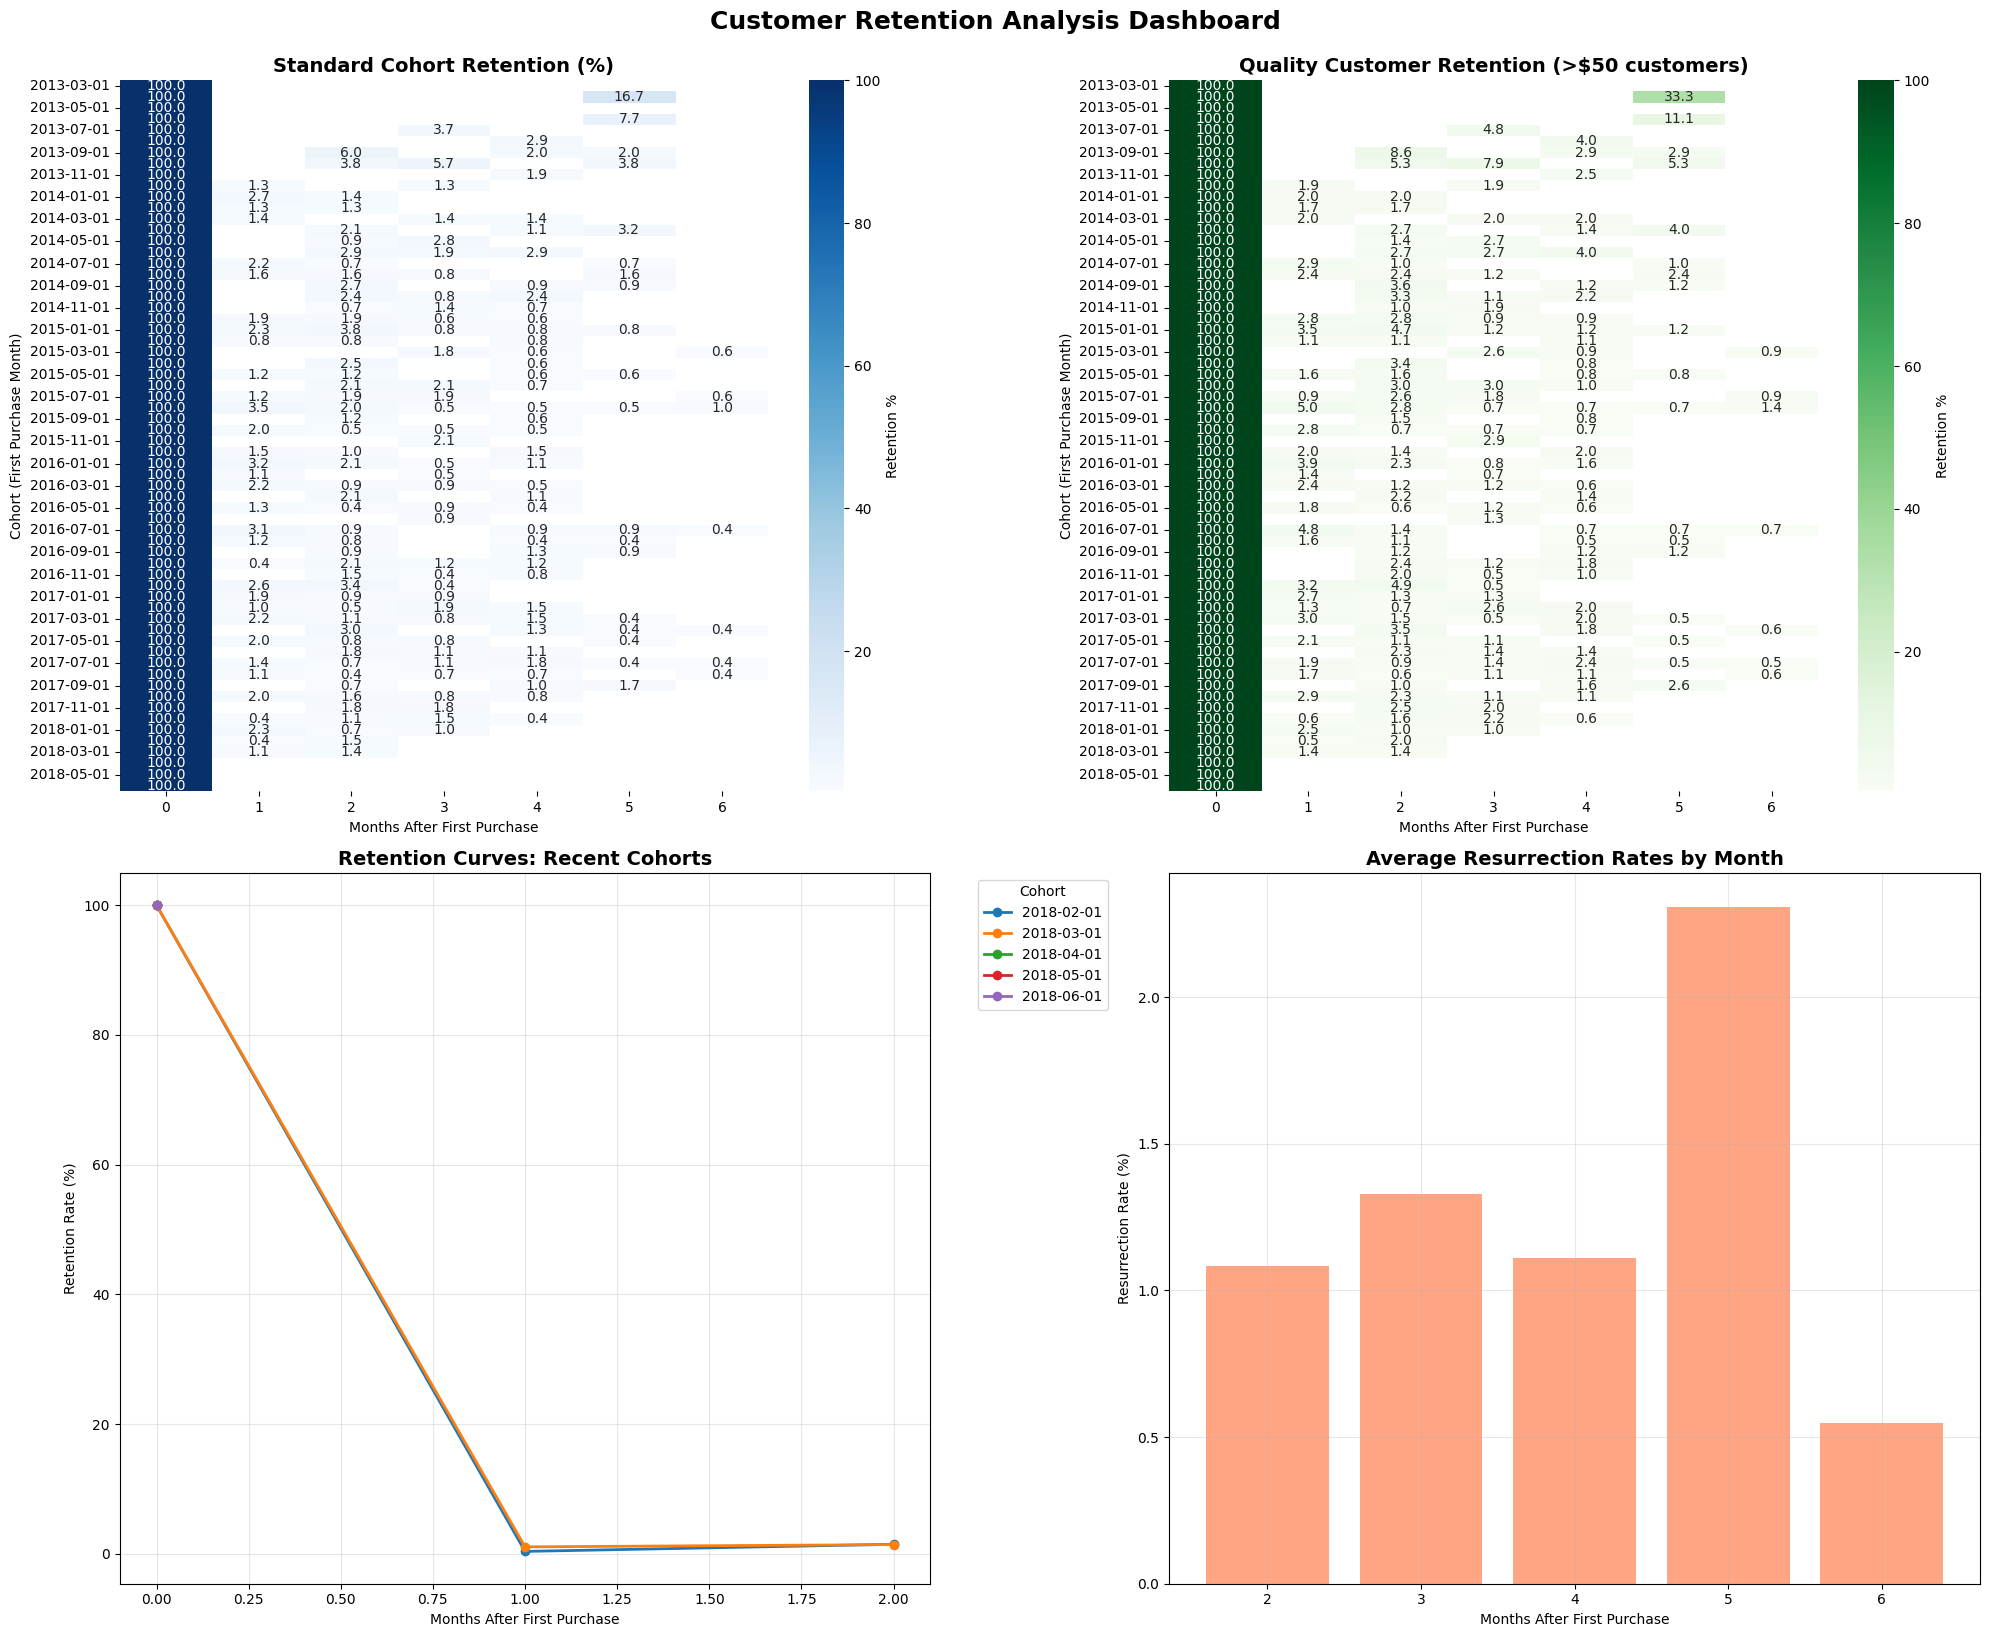

In [24]:
# Customer Retention Analysis Dashboard

# Side-by-side comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Top Left: Standard Cohort Heatmap
sns.heatmap(cohort_pivot, annot=True, fmt='.1f', cmap='Blues', ax=ax1, cbar_kws={'label': 'Retention %'})
ax1.set_title('Standard Cohort Retention (%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Months After First Purchase')
ax1.set_ylabel('Cohort (First Purchase Month)')

# Top Right: Quality Retention Heatmap
sns.heatmap(quality_pivot, annot=True, fmt='.1f', cmap='Greens', ax=ax2, cbar_kws={'label': 'Retention %'})
ax2.set_title('Quality Customer Retention (>$50 customers)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Months After First Purchase')
ax2.set_ylabel('Cohort (First Purchase Month)')

# Bottom Left: Retention Curves by Cohort
for cohort in cohort_pivot.index[-5:]:  # Show last 5 cohorts
    cohort_data = cohort_pivot.loc[cohort].dropna()
    ax3.plot(cohort_data.index, cohort_data.values, marker='o', label=cohort, linewidth=2)
ax3.set_title('Retention Curves: Recent Cohorts', fontsize=14, fontweight='bold')
ax3.set_xlabel('Months After First Purchase')
ax3.set_ylabel('Retention Rate (%)')
ax3.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# Bottom Right: Resurrection Rates
if len(resurrection_pivot) > 0:
    resurrection_avg = resurrection_pivot.mean()
    ax4.bar(resurrection_avg.index, resurrection_avg.values, color='coral', alpha=0.7)
    ax4.set_title('Average Resurrection Rates by Month', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Months After First Purchase')
    ax4.set_ylabel('Resurrection Rate (%)')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Customer Retention Analysis Dashboard', fontsize=18, fontweight='bold', y=1.02)
plt.show()

In [ ]:
# Month 6 retention waterfall

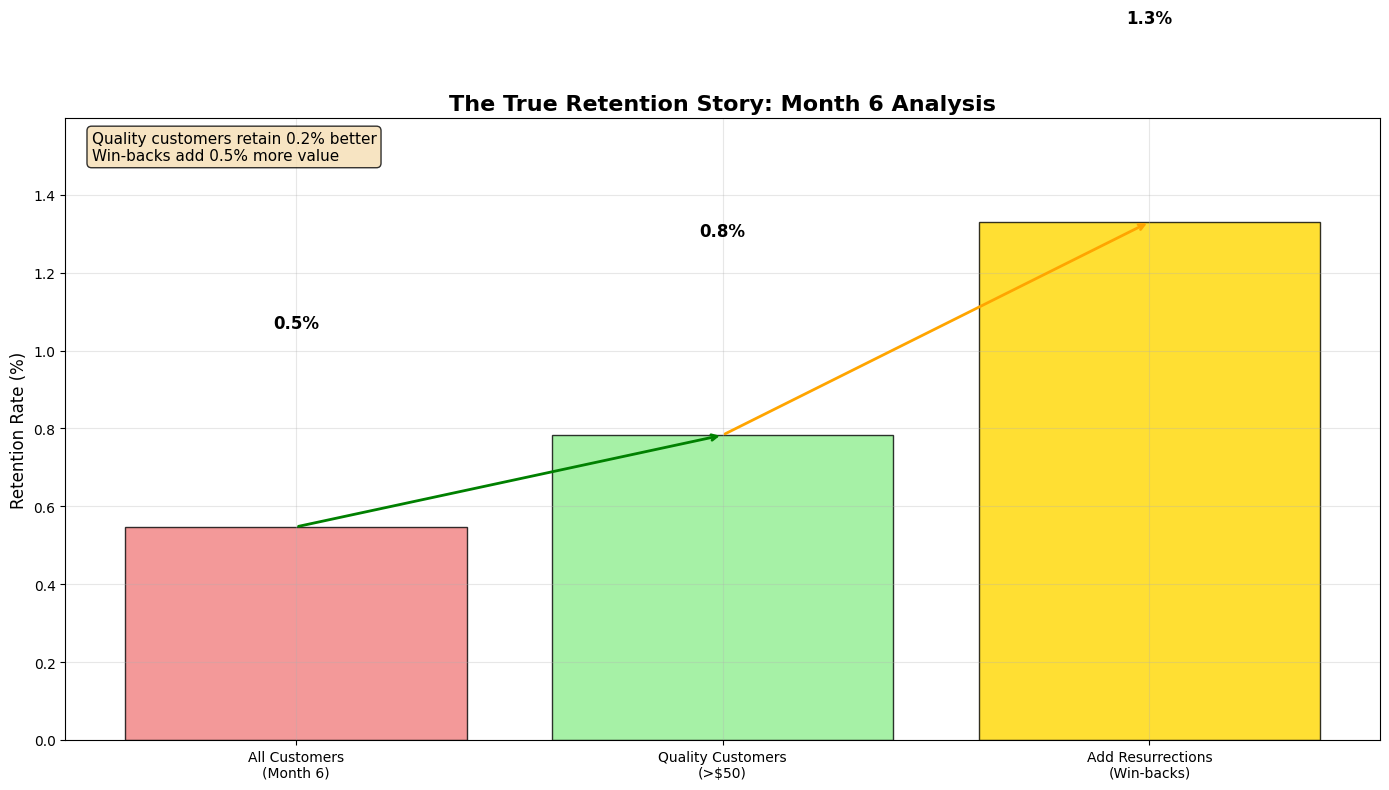

In [ ]:
# Show the progression: All Customers → Quality Customers → With Resurrections
fig, ax = plt.subplots(figsize=(14, 8))

# Get Month 6 data
month6_standard = retention_rates[retention_rates['period_number'] == 6]['retention_rate'].mean()
month6_quality = quality_retention[quality_retention['period_number'] == 6]['quality_retention_rate'].mean()
month6_resurrections = resurrection_rates[resurrection_rates['period_number'] == 6]['resurrection_rate'].mean()

# Create waterfall data
categories = ['All Customers\n(Month 6)', 'Quality Customers\n(>$50)', 'Add Resurrections\n(Win-backs)']
values = [month6_standard, month6_quality, month6_quality + month6_resurrections]
colors = ['lightcoral', 'lightgreen', 'gold']

bars = ax.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Add arrows showing improvement
ax.annotate('', xy=(1, month6_quality), xytext=(0, month6_standard),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))
ax.annotate('', xy=(2, month6_quality + month6_resurrections), xytext=(1, month6_quality),
            arrowprops=dict(arrowstyle='->', color='orange', lw=2))

ax.set_title('The True Retention Story: Month 6 Analysis', fontsize=16, fontweight='bold')
ax.set_ylabel('Retention Rate (%)', fontsize=12)
ax.set_ylim(0, max(values) * 1.2)
ax.grid(True, alpha=0.3)

# Add insight boxes
textstr = f'Quality customers retain {month6_quality - month6_standard:.1f}% better\nWin-backs add {month6_resurrections:.1f}% more value'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

In [ ]:
# Cohort quality analysis over time

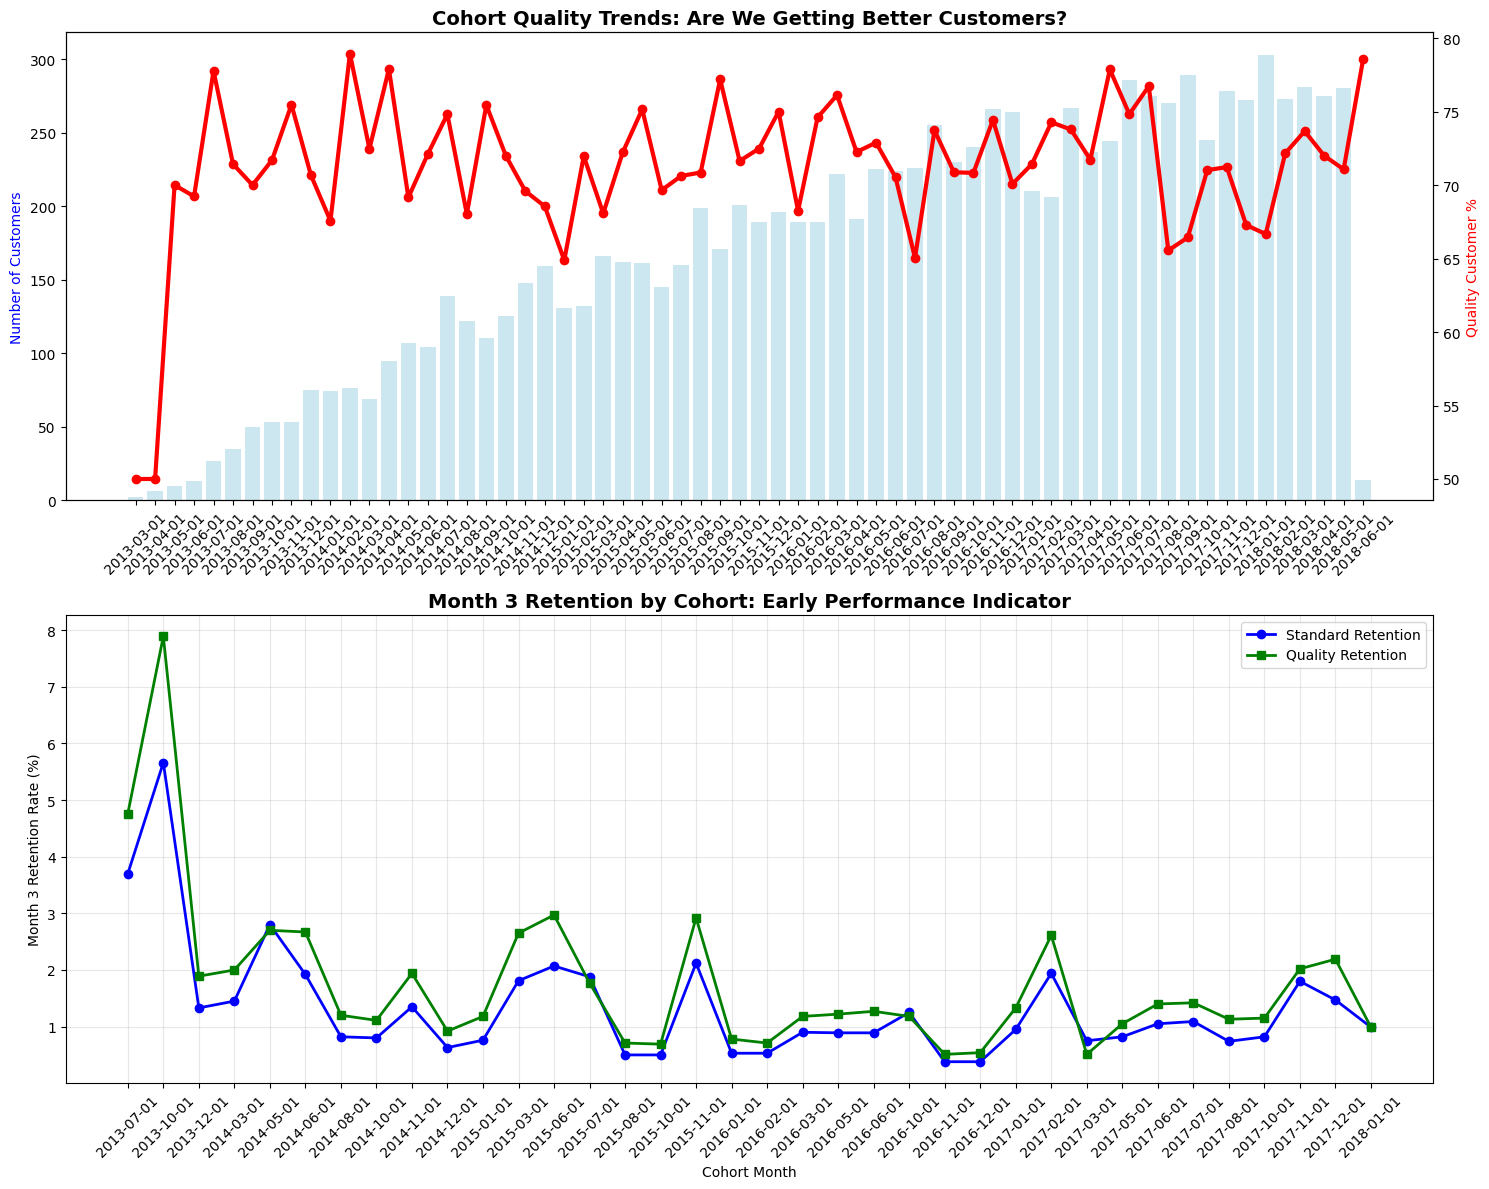

In [ ]:
# Show if customer quality is improving over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Top: Cohort sizes and quality percentages
cohort_analysis = []
for cohort in cohort_pivot.index:
    total_customers = cohort_sizes[cohort_sizes['cohort_month'] == cohort]['cohort_size'].iloc[0]
    quality_customers_count = len(quality_customers[quality_customers['cohort_month'] == cohort])
    quality_pct = (quality_customers_count / total_customers) * 100

    cohort_analysis.append({
        'cohort': cohort,
        'total_customers': total_customers,
        'quality_customers': quality_customers,
        'quality_percentage': quality_pct
    })

cohort_df = pd.DataFrame(cohort_analysis)

# Plot cohort size and quality percentage
ax1_twin = ax1.twinx()
bars = ax1.bar(cohort_df['cohort'], cohort_df['total_customers'], alpha=0.6, color='lightblue', label='Total Customers')
line = ax1_twin.plot(cohort_df['cohort'], cohort_df['quality_percentage'], color='red', marker='o', linewidth=3, label='Quality %')

ax1.set_title('Cohort Quality Trends: Are We Getting Better Customers?', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Customers', color='blue')
ax1_twin.set_ylabel('Quality Customer %', color='red')
ax1.tick_params(axis='x', rotation=45)

# Bottom: Month 3 retention by cohort (early predictor)
month3_retention = retention_rates[retention_rates['period_number'] == 3].copy()
month3_quality = quality_retention[quality_retention['period_number'] == 3].copy()

ax2.plot(month3_retention['cohort_month'], month3_retention['retention_rate'],
         marker='o', linewidth=2, label='Standard Retention', color='blue')
ax2.plot(month3_quality['cohort_month'], month3_quality['quality_retention_rate'],
         marker='s', linewidth=2, label='Quality Retention', color='green')

ax2.set_title('Month 3 Retention by Cohort: Early Performance Indicator', fontsize=14, fontweight='bold')
ax2.set_ylabel('Month 3 Retention Rate (%)')
ax2.set_xlabel('Cohort Month')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Cohort lifestyle visualization

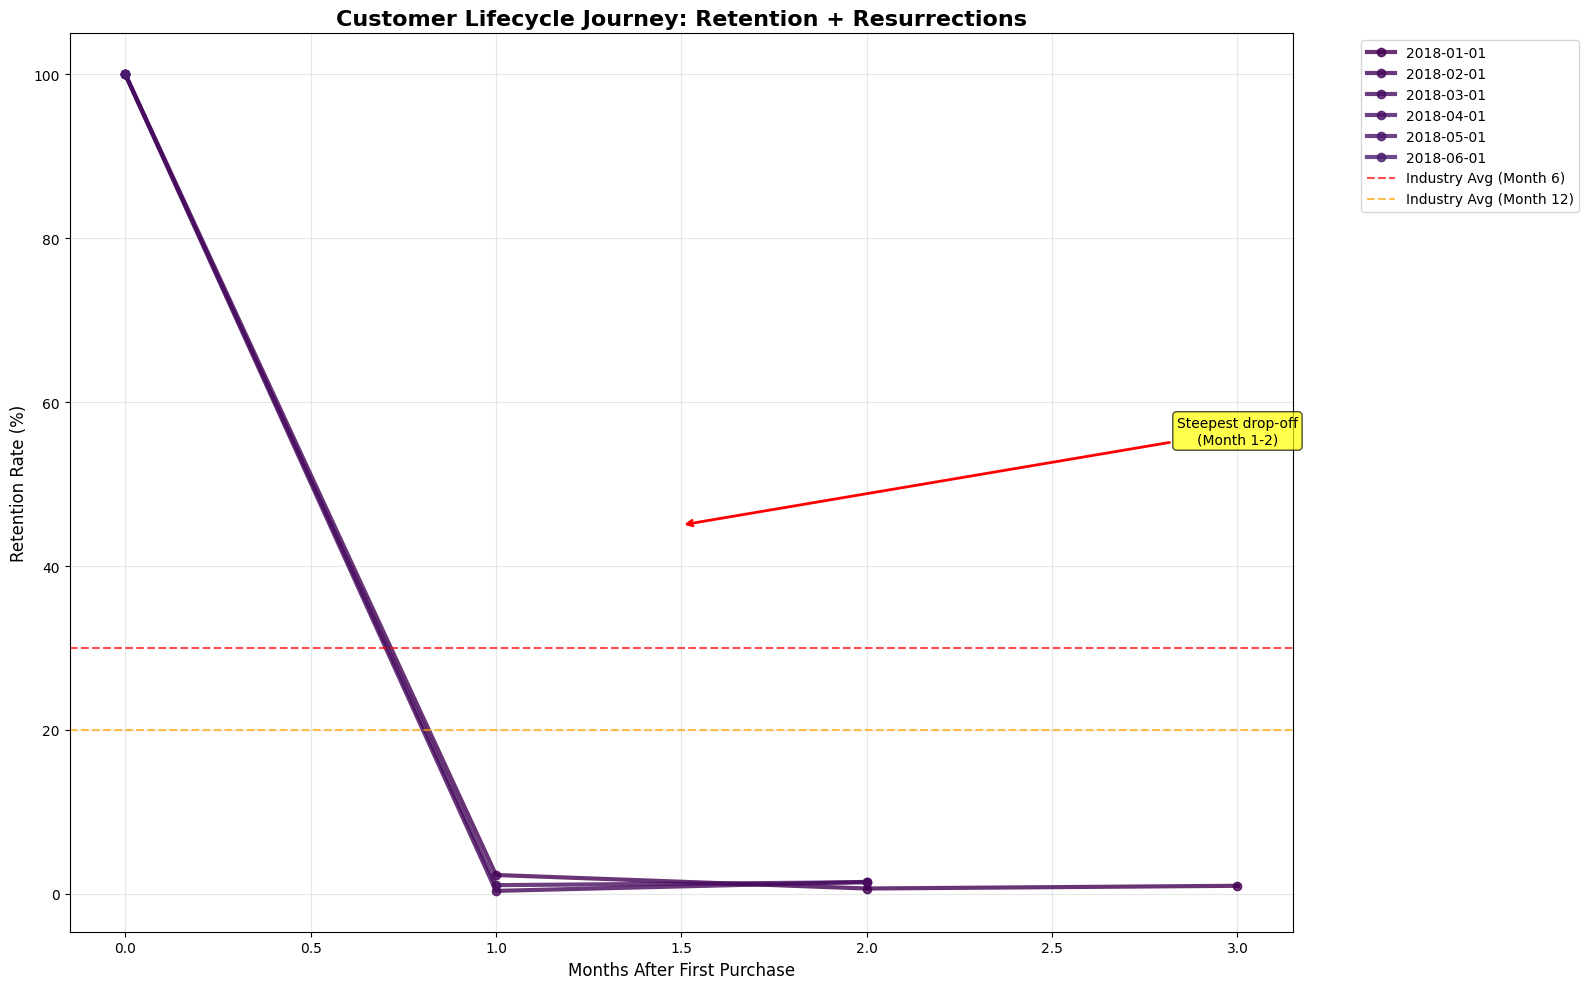

In [ ]:
# Create a compelling lifecycle view
fig, ax = plt.subplots(figsize=(16, 10))

# Create a comprehensive view showing the customer journey
months = range(0, 13)
colors = plt.cm.viridis(np.linspace(0, 1, len(cohort_pivot.index)))

for i, cohort in enumerate(cohort_pivot.index[-6:]):  # Last 6 cohorts
    cohort_data = cohort_pivot.loc[cohort].reindex(months, fill_value=np.nan)

    # Main retention line
    ax.plot(months, cohort_data, marker='o', linewidth=3,
            label=f'{cohort}', color=colors[i], alpha=0.8)

    # Add resurrection points
    if cohort in resurrection_pivot.index:
        resurrection_data = resurrection_pivot.loc[cohort].reindex(months, fill_value=0)
        resurrection_points = resurrection_data[resurrection_data > 0]
        if len(resurrection_points) > 0:
            ax.scatter(resurrection_points.index,
                      cohort_data[resurrection_points.index] + resurrection_points * 0.1,
                      s=resurrection_points * 10, alpha=0.6,
                      color=colors[i], marker='^', label='_nolegend_')

# Add industry benchmarks (you can look these up or estimate)
ax.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='Industry Avg (Month 6)')
ax.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='Industry Avg (Month 12)')

ax.set_title('Customer Lifecycle Journey: Retention + Resurrections', fontsize=16, fontweight='bold')
ax.set_xlabel('Months After First Purchase', fontsize=12)
ax.set_ylabel('Retention Rate (%)', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Add annotations for key insights
ax.annotate('Steepest drop-off\n(Month 1-2)', xy=(1.5, 45), xytext=(3, 55),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax.annotate('Win-back opportunities\n(Triangles = resurrections)',
            xy=(6, 25), xytext=(8, 35),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.show()

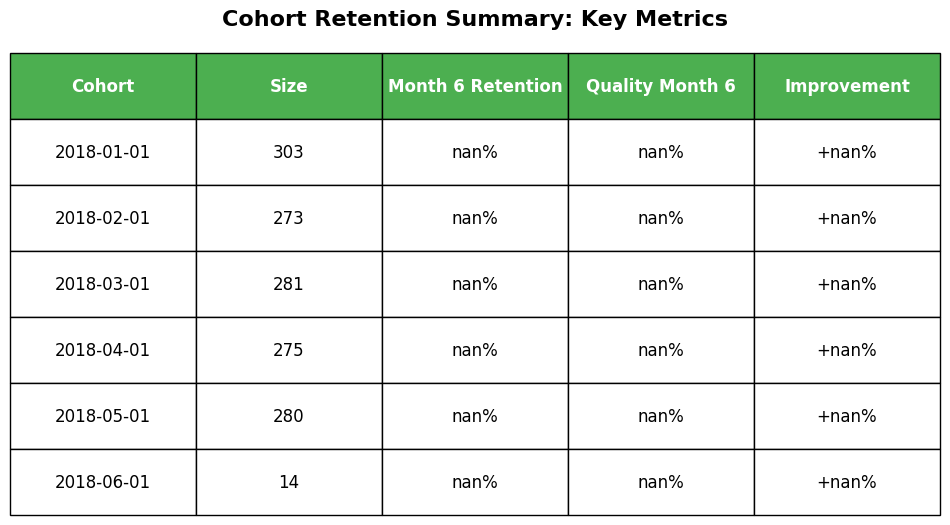

In [ ]:
# Create a professional summary table
summary_data = []

for cohort in cohort_pivot.index[-6:]:  # Last 6 cohorts for relevance
    standard_month6 = cohort_pivot.loc[cohort, 6] if 6 in cohort_pivot.columns else None
    quality_month6 = quality_pivot.loc[cohort, 6] if cohort in quality_pivot.index and 6 in quality_pivot.columns else None
    cohort_size = cohort_sizes[cohort_sizes['cohort_month'] == cohort]['cohort_size'].iloc[0]

    summary_data.append({
        'Cohort': cohort,
        'Size': cohort_size,
        'Month 6 Retention': f"{standard_month6:.1f}%" if standard_month6 else "N/A",
        'Quality Month 6': f"{quality_month6:.1f}%" if quality_month6 else "N/A",
        'Improvement': f"+{quality_month6 - standard_month6:.1f}%" if standard_month6 and quality_month6 else "N/A"
    })

summary_df = pd.DataFrame(summary_data)

# Create a nice table visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns,
                cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)

# Style the table
for i in range(len(summary_df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Cohort Retention Summary: Key Metrics', fontsize=16, fontweight='bold', pad=20)
plt.show()

In [25]:
## Customer Lifetime Value & Acquisition Efficiency

In [26]:
# Data preparation and feature engineering

In [27]:
# Create additional features for analysis
orders_df['order_date'] = orders_df['created_at'].dt.date
orders_df['year_month'] = orders_df['created_at'].dt.to_period('M')

# Calculate customer first purchase date
customer_first_purchase = orders_df.groupby('user_id')['created_at'].min().reset_index()
customer_first_purchase.columns = ['user_id', 'first_purchase_date']

# Merge back to main dataset
orders_df = orders_df.merge(customer_first_purchase, on='user_id', how='left')

# Calculate days since first purchase
orders_df['days_since_first_purchase'] = (orders_df['created_at'] - orders_df['first_purchase_date']).dt.days

# Identify first 90 days behavior
orders_df['is_first_90_days'] = orders_df['days_since_first_purchase'] <= 90

print("Data preparation completed")

Data preparation completed


In [ ]:
# Customer segmentation based on first 90 days

In [28]:
# Calculate customer metrics for first 90 days
first_90_days = orders_df[orders_df['is_first_90_days'] == True]

customer_90_day_metrics = first_90_days.groupby('user_id').agg({
    'invoice_id': 'nunique',  # Number of unique orders
    'price': ['sum', 'mean', 'count'],  # Total spend, AOV, items bought
    'created_at': ['min', 'max']  # First and last purchase in 90 days
}).reset_index()

# Flatten column names
customer_90_day_metrics.columns = ['user_id', 'orders_90d', 'total_spend_90d',
                                 'avg_order_value_90d', 'items_90d',
                                 'first_purchase_90d', 'last_purchase_90d']

# Calculate days active within first 90 days
customer_90_day_metrics['days_active_90d'] = (
    customer_90_day_metrics['last_purchase_90d'] -
    customer_90_day_metrics['first_purchase_90d']
).dt.days + 1

# Calculate purchase frequency (orders per month in first 90 days)
customer_90_day_metrics['purchase_frequency_90d'] = (
    customer_90_day_metrics['orders_90d'] /
    (customer_90_day_metrics['days_active_90d'] / 30)
).fillna(1)  # Handle single-day customers

# Create segmentation criteria
def segment_customers(row):
    is_repeat = row['orders_90d'] > 1
    is_high_value = row['total_spend_90d'] >= 50  # Adjust threshold as needed

    if is_repeat and is_high_value:
        return 'High Value Repeat'
    elif is_repeat and not is_high_value:
        return 'Low Value Repeat'
    elif not is_repeat and is_high_value:
        return 'High Value Single'
    else:
        return 'Low Value Single'

customer_90_day_metrics['segment'] = customer_90_day_metrics.apply(segment_customers, axis=1)

print("Customer segmentation completed")
print("\nSegment distribution:")
print(customer_90_day_metrics['segment'].value_counts())

print(len(customer_90_day_metrics))
print(len(first_90_days))
print(len(orders_df))

print("\nValidation - Date Comparison:")
print("First 90 days date range:")
print(f"Min first_purchase_90d: {customer_90_day_metrics['first_purchase_90d'].min()}")
print(f"Max last_purchase_90d: {customer_90_day_metrics['last_purchase_90d'].max()}")

Customer segmentation completed

Segment distribution:
segment
High Value Single    7403
Low Value Single     3099
High Value Repeat     359
Low Value Repeat       30
Name: count, dtype: int64
10891
28352
28797

Validation - Date Comparison:
First 90 days date range:
Min first_purchase_90d: 2013-03-12 05:53:00
Max last_purchase_90d: 2018-06-01 23:55:00


In [ ]:
# Calculate full customer lifetime metrics

In [29]:
# Calculate full customer lifetime metrics
customer_lifetime_metrics = orders_df.groupby('user_id').agg({
    'invoice_id': 'nunique',  # Total orders
    'price': ['sum', 'mean'],  # Total spend, AOV
    'created_at': ['min', 'max', 'count']  # First purchase, last purchase, frequency
}).reset_index()

# Flatten column names
customer_lifetime_metrics.columns = ['user_id', 'total_orders', 'total_spend',
                                    'avg_lifetime_aov', 'first_purchase',
                                    'last_purchase', 'total_items']

# Calculate customer lifespan in months
customer_lifetime_metrics['lifespan_days'] = (
    customer_lifetime_metrics['last_purchase'] -
    customer_lifetime_metrics['first_purchase']
).dt.days + 1

customer_lifetime_metrics['lifespan_months'] = customer_lifetime_metrics['lifespan_days'] / 30

# Calculate purchase frequency (orders per month)
customer_lifetime_metrics['purchase_frequency'] = (
    customer_lifetime_metrics['total_orders'] /
    customer_lifetime_metrics['lifespan_months']
)

# Handle customers with single purchases (lifespan = 1 day)
customer_lifetime_metrics['purchase_frequency'] = customer_lifetime_metrics['purchase_frequency'].fillna(1)

# Merge with segmentation
customer_analysis = customer_90_day_metrics.merge(
    customer_lifetime_metrics, on='user_id', how='left'
)

print("Lifetime metrics calculation completed")
print("\nCustomer analysis with segmentation:")
print(customer_analysis.head(10))

Lifetime metrics calculation completed

Customer analysis with segmentation:
   user_id  orders_90d  total_spend_90d  avg_order_value_90d  items_90d  \
0       17           1          243.000               81.000          3   
1       63           1          585.000              195.000          3   
2       69           1            9.420                2.355          4   
3       98           1          390.000              390.000          1   
4      100           1          209.000              104.500          2   
5      105           1            0.000                0.000          1   
6      125           1          270.000              270.000          1   
7      145           1          387.500              193.750          2   
8      198           1            3.195                1.065          3   
9      199           1            9.000                9.000          1   

   first_purchase_90d   last_purchase_90d  days_active_90d  \
0 2013-05-24 22:00:00 2013-05-24 22

In [30]:
# VALIDATION: Comparing 90-day vs lifetime metrics
validation_merge = customer_analysis[['user_id', 'last_purchase_90d', 'last_purchase']].copy()

# Check customers who made purchases beyond 90 days
beyond_90_days = validation_merge[
    validation_merge['last_purchase'] > validation_merge['last_purchase_90d']
]

print(f"\nValidation Results:")
print(f"Total customers: {len(validation_merge)}")
print(f"Customers with purchases beyond 90 days: {len(beyond_90_days)}")
print(f"Customers with only 90-day purchases: {len(validation_merge) - len(beyond_90_days)}")

# Show examples of customers with different dates
if len(beyond_90_days) > 0:
    print(f"\nExample customers with purchases beyond 90 days:")
    sample = beyond_90_days.head(5)
    for _, row in sample.iterrows():
        print(f"Customer {row['user_id']}: Last 90d = {row['last_purchase_90d']}, "
              f"Lifetime = {row['last_purchase']}")
else:
    print("\nNote: All customers made purchases only within their first 90 days")


Validation Results:
Total customers: 10891
Customers with purchases beyond 90 days: 169
Customers with only 90-day purchases: 10722

Example customers with purchases beyond 90 days:
Customer 1009: Last 90d = 2013-04-28 21:08:00, Lifetime = 2013-09-01 10:56:00
Customer 1622: Last 90d = 2013-06-16 05:43:00, Lifetime = 2013-11-04 00:10:00
Customer 3289: Last 90d = 2013-08-04 20:33:00, Lifetime = 2013-12-17 04:36:00
Customer 5696: Last 90d = 2013-09-08 07:57:00, Lifetime = 2014-03-09 14:18:00
Customer 6831: Last 90d = 2013-09-27 20:38:00, Lifetime = 2014-01-11 06:00:00


In [42]:
# Calculate CLV components by segment
def calculate_clv_by_segment(df):
    clv_by_segment = customer_analysis.groupby('segment').agg({
        'user_id': 'count',  # Number of customers
        'avg_lifetime_aov': 'mean',  # Average Order Value
        'purchase_frequency': 'mean',  # Purchase frequency (orders/month)
        'lifespan_months': 'mean',  # Average lifespan
        'total_spend': 'mean'  # Average total spend
    }).reset_index()

    clv_by_segment.columns = ['segment', 'customer_count', 'avg_order_value',
                             'avg_purchase_frequency', 'avg_lifespan_months',
                             'avg_total_spend']

    # Calculate predicted CLV
    clv_by_segment['predicted_clv'] = (
        clv_by_segment['avg_order_value'] *
        clv_by_segment['avg_purchase_frequency'] *
        clv_by_segment['avg_lifespan_months']
    )

    # Calculate maximum allowable CAC (assuming 3:1 LTV:CAC ratio)
    clv_by_segment['max_cac'] = clv_by_segment['predicted_clv'] / 3

    return clv_by_segment

segment_clv = calculate_clv_by_segment(customer_analysis)

print("CLV calculation by segment:")
print(segment_clv.round(2))
print(customer_analysis.columns)

CLV calculation by segment:
             segment  customer_count  avg_order_value  avg_purchase_frequency  \
0  High Value Repeat             359           106.36                    3.90   
1  High Value Single            7403           139.55                   29.56   
2   Low Value Repeat              30             6.22                    3.03   
3   Low Value Single            3099            13.83                   29.50   

   avg_lifespan_months  avg_total_spend  predicted_clv  max_cac  
0                 1.43           550.21         591.27   197.09  
1                 0.10           358.55         396.18   132.06  
2                 1.52            25.80          28.75     9.58  
3                 0.11            24.77          43.09    14.36  
Index(['user_id', 'orders_90d', 'total_spend_90d', 'avg_order_value_90d',
       'items_90d', 'first_purchase_90d', 'last_purchase_90d',
       'days_active_90d', 'purchase_frequency_90d', 'segment', 'total_orders',
       'total_spend'

In [ ]:
# Validation compare predicted vs actual clv

In [44]:
# Filter customers with 12+ months history
cutoff_date = orders_df['created_at'].max() - timedelta(days=365)
customers_12m_plus = customer_analysis[
    customer_analysis['first_purchase'] <= cutoff_date
].copy()

# Merge with segment CLV predictions
customers_12m_plus = customers_12m_plus.merge(
    segment_clv[['segment', 'predicted_clv']],
    on='segment',
    how='left'
)

# Calculate actual CLV for validation
validation_data = customers_12m_plus.groupby('segment').agg({
    'user_id': 'count',
    'total_spend': 'mean',
    'predicted_clv': 'mean'
}).reset_index()

validation_data.columns = ['segment', 'validation_customers', 'actual_clv', 'predicted_clv']
validation_data['clv_accuracy'] = validation_data['actual_clv'] / validation_data['predicted_clv']
validation_data['absolute_error'] = abs(validation_data['actual_clv'] - validation_data['predicted_clv'])
validation_data['error_percentage'] = (validation_data['absolute_error'] / validation_data['actual_clv']) * 100

print("CLV Validation Results:")
print(validation_data.round(2))

# Additional validation metrics
print(f"\nValidation Summary:")
print(f"Total customers with 12+ months history: {customers_12m_plus.shape[0]}")
print(f"Average prediction accuracy: {validation_data['clv_accuracy'].mean():.2f}")
print(f"Average absolute error: ${validation_data['absolute_error'].mean():.2f}")
print(f"Average error percentage: {validation_data['error_percentage'].mean():.1f}%")

CLV Validation Results:
             segment  validation_customers  actual_clv  predicted_clv  \
0  High Value Repeat                   269      593.76         591.27   
1  High Value Single                  5152      356.60         396.18   
2   Low Value Repeat                    24       25.97          28.75   
3   Low Value Single                  2118       25.29          43.09   

   clv_accuracy  absolute_error  error_percentage  
0          1.00            2.49              0.42  
1          0.90           39.57             11.10  
2          0.90            2.77             10.67  
3          0.59           17.80             70.38  

Validation Summary:
Total customers with 12+ months history: 7563
Average prediction accuracy: 0.85
Average absolute error: $15.66
Average error percentage: 23.1%


In [45]:
# Detailed segment analysis
def analyze_segment_characteristics(df):
    characteristics = df.groupby('segment').agg({
        'user_id': 'count',
        'total_spend_90d': ['mean', 'median', 'std'],
        'orders_90d': ['mean', 'median'],
        'avg_order_value_90d': ['mean', 'median'],
        'total_spend': ['mean', 'median', 'std'],
        'total_orders': ['mean', 'median'],
        'lifespan_months': ['mean', 'median'],
        'purchase_frequency': ['mean', 'median']
    }).round(2)

    return characteristics

segment_characteristics = analyze_segment_characteristics(customer_analysis)
print("Detailed Segment Characteristics:")
print(segment_characteristics)

Detailed Segment Characteristics:
                  user_id total_spend_90d                 orders_90d         \
                    count            mean  median     std       mean median   
segment                                                                       
High Value Repeat     359          548.03  357.52  528.15       2.01    2.0   
High Value Single    7403          354.92  200.25  388.58       1.00    1.0   
Low Value Repeat       30           25.80   27.37   14.08       2.00    2.0   
Low Value Single     3099           20.17   18.00   14.91       1.00    1.0   

                  avg_order_value_90d        total_spend                  \
                                 mean median        mean  median     std   
segment                                                                    
High Value Repeat              106.29  75.00      550.21  359.47  527.75   
High Value Single              139.87  85.62      358.55  204.16  391.49   
Low Value Repeat                

In [46]:
# Create final results table
final_results = segment_clv.copy()

# What percentage of total customers belong to each segment.
final_results['segment_pct'] = (final_results['customer_count'] /
                               final_results['customer_count'].sum() * 100).round(1)

# Add validation accuracy
validation_merge = validation_data[['segment', 'actual_clv', 'clv_accuracy']].copy()
final_results = final_results.merge(validation_merge, on='segment', how='left')

# Reorder columns for better presentation
final_results = final_results[[
    'segment', 'customer_count', 'segment_pct', 'avg_order_value',
    'avg_purchase_frequency', 'avg_lifespan_months', 'predicted_clv',
    'actual_clv', 'clv_accuracy', 'max_cac'
]]

print("Final Results Summary:")
print(final_results.round(2))

Final Results Summary:
             segment  customer_count  segment_pct  avg_order_value  \
0  High Value Repeat             359          3.3           106.36   
1  High Value Single            7403         68.0           139.55   
2   Low Value Repeat              30          0.3             6.22   
3   Low Value Single            3099         28.5            13.83   

   avg_purchase_frequency  avg_lifespan_months  predicted_clv  actual_clv  \
0                    3.90                 1.43         591.27      593.76   
1                   29.56                 0.10         396.18      356.60   
2                    3.03                 1.52          28.75       25.97   
3                   29.50                 0.11          43.09       25.29   

   clv_accuracy  max_cac  
0          1.00   197.09  
1          0.90   132.06  
2          0.90     9.58  
3          0.59    14.36  


In [ ]:
# Visualizations

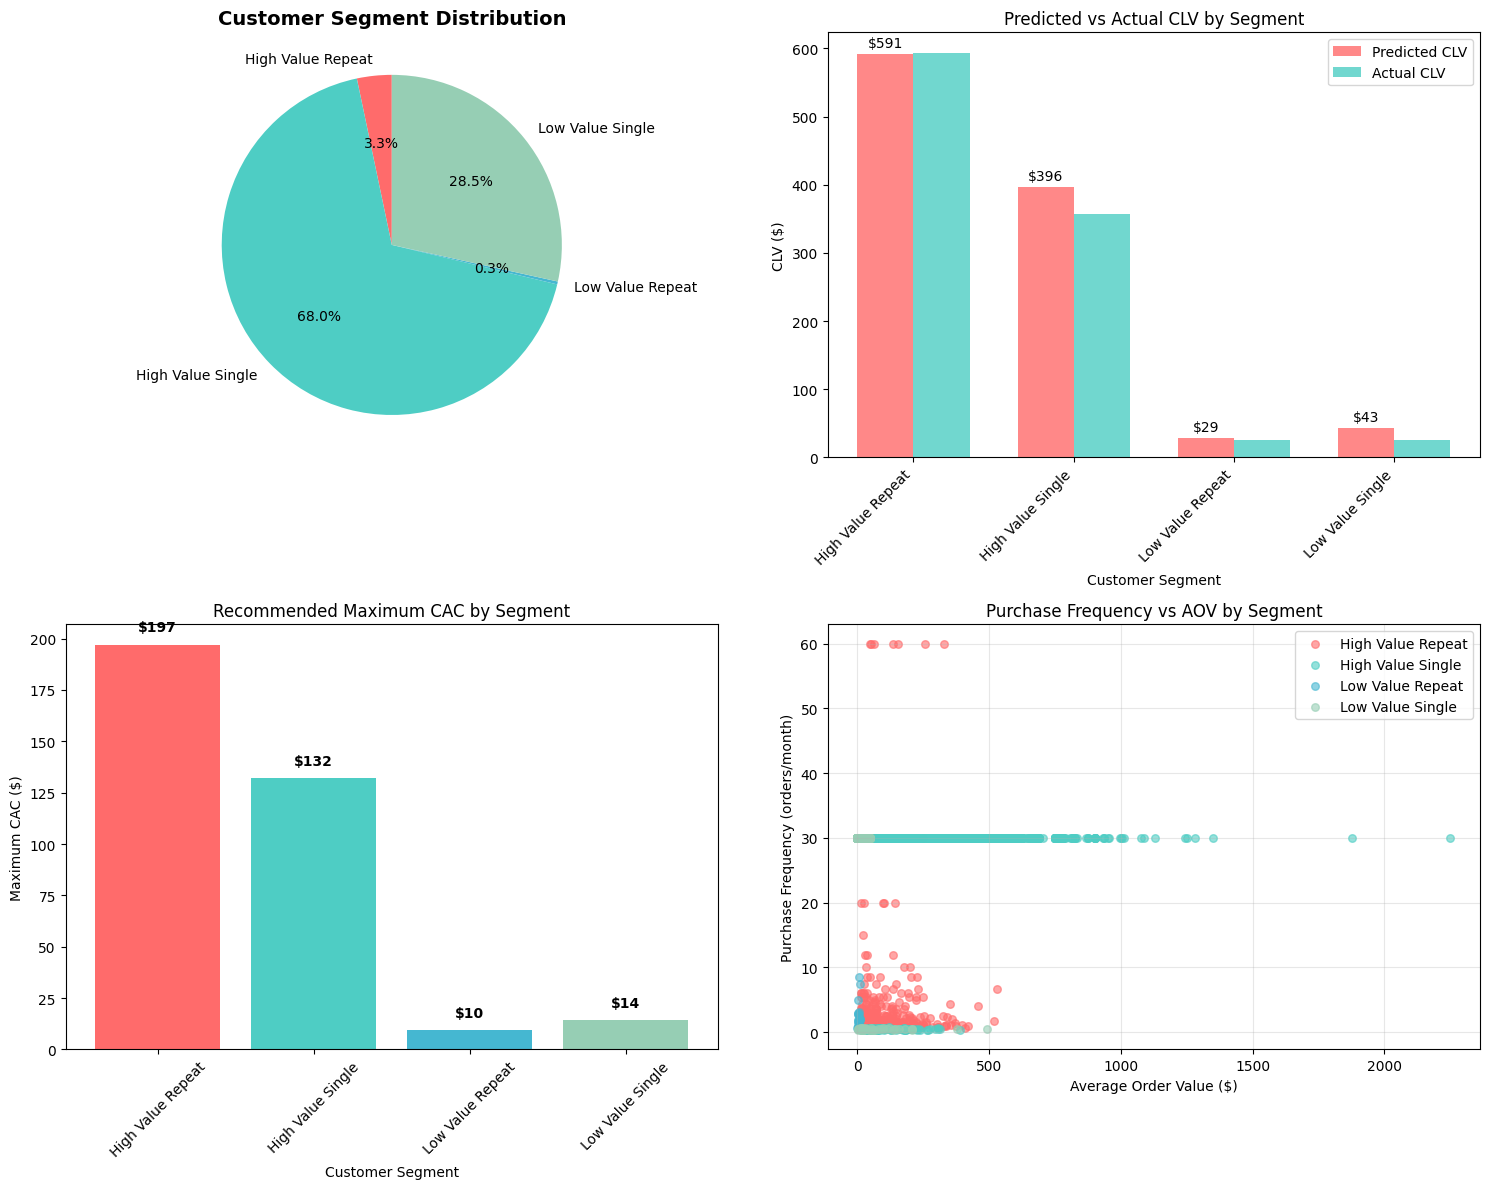

In [48]:
# Segment Distribution and CLV Comparison
# Create subplot figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Segment Distribution
segment_counts = final_results.set_index('segment')['customer_count']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
ax1.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
        colors=colors, startangle=90)
ax1.set_title('Customer Segment Distribution', fontsize=14, fontweight='bold')

# 2. CLV by Segment
segments = final_results['segment']
predicted_clv = final_results['predicted_clv']
actual_clv = final_results['actual_clv'].fillna(0)

x = np.arange(len(segments))
width = 0.35

bars1 = ax2.bar(x - width/2, predicted_clv, width, label='Predicted CLV',
                color='#FF6B6B', alpha=0.8)
bars2 = ax2.bar(x + width/2, actual_clv, width, label='Actual CLV',
                color='#4ECDC4', alpha=0.8)

ax2.set_xlabel('Customer Segment')
ax2.set_ylabel('CLV ($)')
ax2.set_title('Predicted vs Actual CLV by Segment')
ax2.set_xticks(x)
ax2.set_xticklabels(segments, rotation=45, ha='right')
ax2.legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax2.annotate(f'${height:.0f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# 3. Maximum CAC by Segment
ax3.bar(segments, final_results['max_cac'], color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax3.set_xlabel('Customer Segment')
ax3.set_ylabel('Maximum CAC ($)')
ax3.set_title('Recommended Maximum CAC by Segment')
ax3.tick_params(axis='x', rotation=45)

# Add value labels
for i, v in enumerate(final_results['max_cac']):
    ax3.text(i, v + 5, f'${v:.0f}', ha='center', va='bottom', fontweight='bold')

# 4. Purchase Frequency vs AOV Scatter
for i, segment in enumerate(segments):
    segment_data = customer_analysis[customer_analysis['segment'] == segment]
    ax4.scatter(segment_data['avg_lifetime_aov'], segment_data['purchase_frequency'],
               label=segment, color=colors[i], alpha=0.6, s=30)

ax4.set_xlabel('Average Order Value ($)')
ax4.set_ylabel('Purchase Frequency (orders/month)')
ax4.set_title('Purchase Frequency vs AOV by Segment')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-50-278350575.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(clv_data, labels=labels)


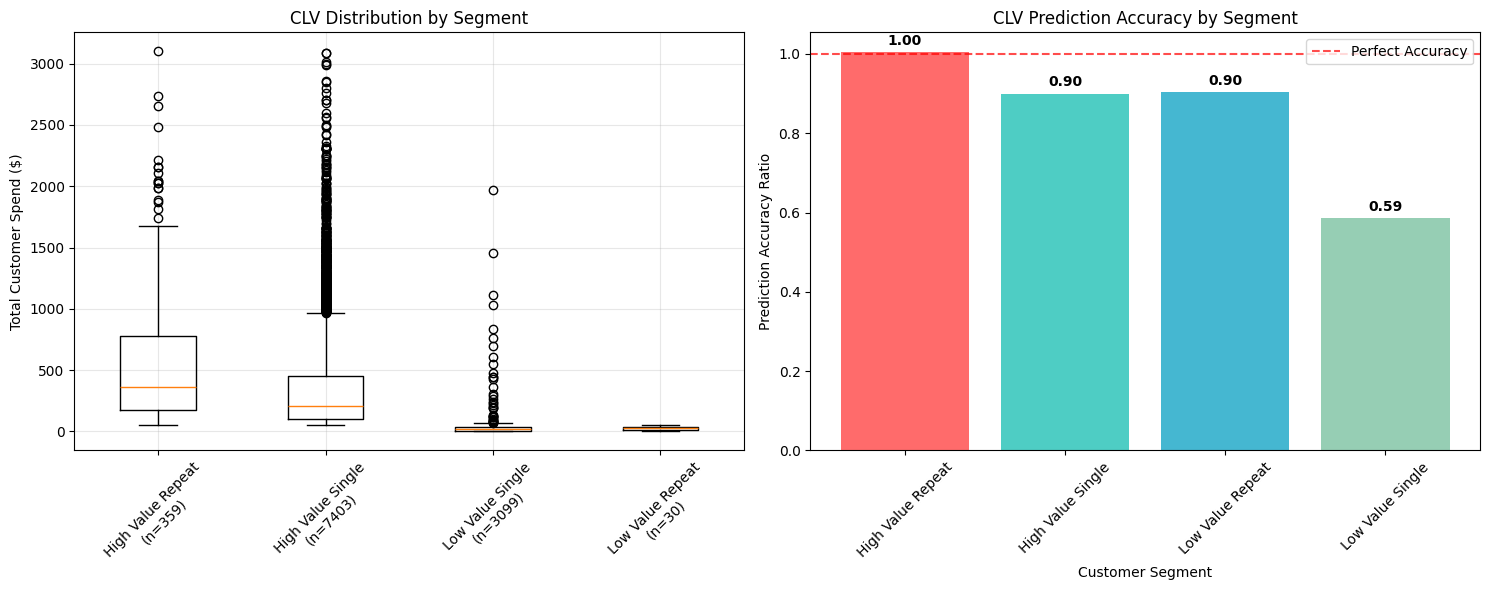

In [50]:
# CLV Distribution and Validation Metrics
# Create additional visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. CLV Distribution by Segment
segment_order = final_results.sort_values('predicted_clv', ascending=False)['segment']
clv_data = []
labels = []

for segment in segment_order:
    segment_customers = customer_analysis[customer_analysis['segment'] == segment]
    clv_data.append(segment_customers['total_spend'].values)
    labels.append(f"{segment}\n(n={len(segment_customers)})")

ax1.boxplot(clv_data, labels=labels)
ax1.set_ylabel('Total Customer Spend ($)')
ax1.set_title('CLV Distribution by Segment')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Validation Accuracy
validation_clean = final_results.dropna(subset=['clv_accuracy'])
bars = ax2.bar(validation_clean['segment'], validation_clean['clv_accuracy'],
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Perfect Accuracy')
ax2.set_xlabel('Customer Segment')
ax2.set_ylabel('Prediction Accuracy Ratio')
ax2.set_title('CLV Prediction Accuracy by Segment')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [52]:
# Create business insights summary
print("="*80)
print("BUSINESS INSIGHTS SUMMARY")
print("="*80)

# Key metrics summary
total_customers = final_results['customer_count'].sum()
weighted_avg_clv = (final_results['predicted_clv'] * final_results['customer_count']).sum() / total_customers
weighted_avg_cac = (final_results['max_cac'] * final_results['customer_count']).sum() / total_customers

print(f"Total Customers Analyzed: {total_customers:,}")
print(f"Weighted Average CLV: ${weighted_avg_clv:.2f}")
print(f"Weighted Average Max CAC: ${weighted_avg_cac:.2f}")
print(f"Average LTV:CAC Ratio: {(weighted_avg_clv/weighted_avg_cac):.1f}:1")

print("\n" + "="*80)
print("MARKETING BUDGET ALLOCATION RECOMMENDATIONS")
print("="*80)

# Calculate suggested budget allocation
total_max_cac = final_results['max_cac'].sum()
for _, row in final_results.iterrows():
    budget_pct = (row['max_cac'] / total_max_cac) * 100
    print(f"{row['segment']}: {budget_pct:.1f}% of acquisition budget")

BUSINESS INSIGHTS SUMMARY
Total Customers Analyzed: 10,891
Weighted Average CLV: $301.13
Weighted Average Max CAC: $100.38
Average LTV:CAC Ratio: 3.0:1

MARKETING BUDGET ALLOCATION RECOMMENDATIONS
High Value Repeat: 55.8% of acquisition budget
High Value Single: 37.4% of acquisition budget
Low Value Repeat: 2.7% of acquisition budget
Low Value Single: 4.1% of acquisition budget
